In [2]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

# Super Dark Generation


Example notebook to create an averaged dark image. For a series of dark ramps:

  1. subtract a superbias frame
  1. perform reference pixel correction
  1. fit the a polynomial (usually linear function) to each pixel within the ramp to find slope image
  1. averages together resulting slope images
  
The result is a final superdark image file in units of DN/sec.

In [3]:
# Reference pixel correction modules and functions
import ref_pixels
from ref_pixels import robust
from ref_pixels import reffix_hxrg, get_fits_data
from ref_pixels import jl_poly_fit, jl_poly

# Astropy FITS
from astropy.io import fits

# Progress bar
from tqdm.auto import trange, tqdm

In [4]:
def _wrap_slope_fit_data(arg):
    """ Wrapper for multiprocessing """
    args, kwargs = arg

    fname, det = args
    data = get_fits_data(fname, reffix=True, **kwargs)

    # Time array
    tarr = det.times_group_avg

    # Perform the polynomial fitting.
    # Default is to use a fit with deg=1
    # Good practice skip the first frame in case of reset overshoot effects    
    deg = kwargs['deg']
    coeff = jl_poly_fit(tarr[1:], data[1:], deg=deg)
    
    # Get median of all pixels at each time step
    vals = np.median(data.reshape([nz,-1]), axis=1)
    # Remove offset
    cf_temp = jl_poly_fit(tarr[1:], vals[1:], deg=deg)
    avg_slope = vals - cf_temp[0]
    
    del data

    return (coeff[1], avg_slope)

def gen_super_dark(allfiles, det, bias=None, deg=1, nproc=4, 
                   mn_func=np.median, std_func=robust.medabsdev, **kwargs):
    """ Generate a Super Dark Image

    Read in a number of dark ramps, subtract a superbias iamge, 
    perform a polynomial fit to the data, and return the average 
    of all slope images. 
    
    Parameters
    ==========
    allfiles : list
        List of FITS files to read.
    det : `det_timing` object
        
    """
    
    import multiprocessing as mp
    
    # Set keywords for multiprocessing
    kw = kwargs.copy()
    kw['deg'] = deg
    kw['bias'] = bias
    worker_args = [([f, det],kw) for f in allfiles]
    
    nfiles = len(allfiles)
    
    log_prev = ref_pixels.conf.logging_level
    ref_pixels.setup_logging('WARN', verbose=False)
    
    dark_all = []  # Holds all slope images for each ramp
    avg_slope = [] # Holds average values per frame for each ramp
    if nproc>1:
        try:
            with mp.Pool(nproc) as pool:
                for res in tqdm(pool.imap_unordered(_wrap_slope_fit_data, worker_args), total=nfiles):
                    dark_all.append(res[0])
                    avg_slope.append(res[1])
                pool.close()

            if dark_all[0] is None:
                raise RuntimeError('Returned None values. Issue with multiprocess??')
        except Exception as e:
            print('Caught an exception during multiprocess.')
            print('Closing multiprocess pool.')
            pool.terminate()
            pool.close()
            raise e
        else:
            print('Closing multiprocess pool.')

    else: # No multiprocessing
        for wa in tqdm(worker_args):
            res = _wrap_slope_fit_data(wa)
            dark_all.append(res[0])
            avg_slope.append(res[1])

    dark_all = np.array(dark_all)
    avg_slope = np.array(avg_slope)
        
    ref_pixels.setup_logging('INFO', verbose=False)

    print('Calculating average and standard deviation...')
    super_dark     = mn_func(dark_all, axis=0)
    super_dark_std = std_func(dark_all,axis=0)
    
    # get average dark slope
    ramp_avg = np.median(avg_slope, axis=0)
    
    res_dict = {
        'super_dark'     : super_dark,
        'super_dark_std' : super_dark_std,
        'ramp_avg'       : ramp_avg,
    }

    return res_dict

## Dark FITS Cubes

List of dark files and pre-calculated superbias image.

In [5]:
import os

indir = '/Users/jarron/SHARK-NIR/20200220_Dark/Dark_250kHz/'
allfits = np.array([indir + f for f in os.listdir(indir) if f.endswith('.fits')])
allfits.sort()

In [6]:
# Read in superbias image
bias_path = '/Users/jarron/SHARK-NIR/20200220_Dark/SHARK-NIR_250Hz_superbias_example.fits'
superbias = get_fits_data(bias_path)

## Detector timing

Define a detector timing object that houses all the necessary information concerning the pixel and frame clocking, detector size and output channels, etc.

In [7]:
# Get shape information for input file
hdul = fits.open(allfits[0])
nz, ny, nx = hdul[0].data.shape
hdul.close()

# Detector timing info
if nx<2048 and ny<2048:
    wind_mode = 'WINDOW'
elif ny<2048:
    wind_mode = 'STRIPE'
else:
    wind_mode = 'FULL'
    
det = ref_pixels.detops.det_timing(mode='SHARK_250', wind_mode=wind_mode, xpix=nx, ypix=ny, ngroup=nz)

[    refpix:INFO] RAPID readout mode selected.
[    refpix:INFO] Setting nf=1, nd1=0, nd2=0, nd3=0.


In [8]:
# Double check basic frame size and setup information
print(det.to_dict())

{'wind_mode': 'FULL', 'nout': 4, 'xpix': 2048, 'ypix': 2048, 'x0': 0, 'y0': 0}


In [9]:
# Check timing information makes sense
det.times_to_dict()

{'t_frame': 4.278316,
 't_group': 4.278316,
 't_int': 106.9579,
 't_exp': 106.9579,
 't_acq': 111.238304,
 't_int_tot1': 111.236216,
 't_int_tot2': 0.0}

In [10]:
# Time array
tarr = det.times_group_avg
print(tarr)

[  4.278316   8.556632  12.834948  17.113264  21.39158   25.669896
  29.948212  34.226528  38.504844  42.78316   47.061476  51.339792
  55.618108  59.896424  64.17474   68.453056  72.731372  77.009688
  81.288004  85.56632   89.844636  94.122952  98.401268 102.679584
 106.9579  ]


## Create super dark image

Call the function that will perform the reference pixel correction and frame fitting in order to cacluate the final calibration image.

In [11]:
# Keyword arguments to pass to reference pixel correction before slope fitting
kw_refpix = {
    'nchans': det.nout, 'altcol': True, 'in_place': True,
    'fixcol': True, 'avg_type': 'pixel', 'savgol': True, 'perint': False    
}

res = gen_super_dark(allfits, det, bias=superbias, **kw_refpix)

  0%|          | 0/20 [00:00<?, ?it/s]

Closing multiprocess pool.
Calculating average and standard deviation...


In [12]:
# Returns a dictionary
print(res.keys())

dict_keys(['super_dark', 'super_dark_std', 'ramp_avg'])


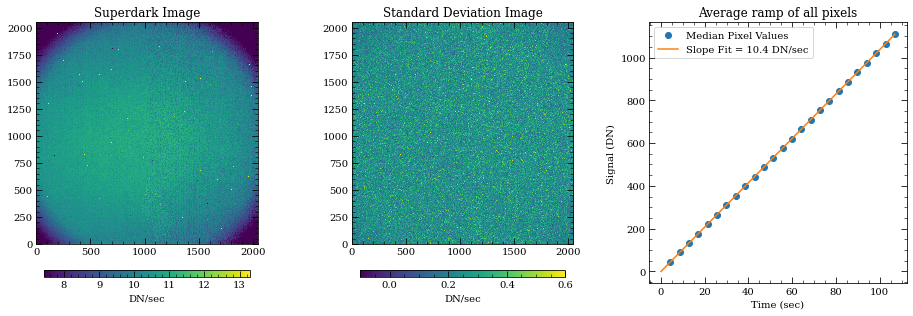

In [13]:
fig, axes = plt.subplots(1,3, figsize=(13,4.5))

titles = ['Superdark Image', 'Standard Deviation Image']
for i, im in enumerate([res['super_dark'], res['super_dark_std']]):
    ax = axes[i]
    
    mn = np.median(im)
    std = robust.std(im)
    vmin, vmax = mn + 5*std*np.array([-1,1])
    
    ax_out = ax.imshow(im, vmin=vmin, vmax=vmax)
    ax.set_title(titles[i])
    
    cbar = fig.colorbar(ax_out, ax=ax, orientation='horizontal', label='DN/sec',
                        pad=0.1, fraction=0.05, aspect=30, shrink=0.8)
    
ax = axes[2]
# Check linearity over flux range
ax.plot(tarr, res['ramp_avg'], marker='o', ls='none', label='Median Pixel Values')

# Perform linear fit to average ramp data
cf = jl_poly_fit(tarr, res['ramp_avg'])
label = f'Slope Fit = {cf[1]:.1f} DN/sec'
tcalc = np.linspace(0,tarr.max(),100)
ax.plot(tcalc, jl_poly(tcalc, cf), label=label)

ax.set_title("Average ramp of all pixels")
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Signal (DN)')

ax.legend()

fig.tight_layout()

In [14]:
# Save superbias to file
outdir = '/Users/jarron/SHARK-NIR/20200220_Dark/'
file_out = 'SHARK-NIR_250Hz_superdark_example.fits'

hdu = fits.PrimaryHDU(res['super_dark'])
hdu.writeto(outdir + file_out, overwrite=True)